# 🌊 **Water Segmentation using Multispectral Data**

The goal of this project is to **develop a robust model for extracting water bodies** from satellite multispectral imagery.  
Accurate water segmentation is important for monitoring water resources, flood management, and environmental protection.  

We will experiment with two main approaches:  
1. **Model 1**: Using all available spectral bands.  
2. **Model 2**: Using selected spectral bands (SWIR1, SWIR2, NIR).  

Finally, we will compare model performance using metrics such as **IoU, F1-Score, Precision, and Recall**,  
and visualize sample predictions against ground truth masks.

In [2]:
import os
import zipfile
import random
from PIL import Image
import cv2
import tifffile as tiff
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras import Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Input, Dropout, UpSampling2D, concatenate
from keras.regularizers import l2
from keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, BinaryIoU
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0

os.environ['SM_FRAMEWORK'] = 'tf.keras'
from segmentation_models import Unet

Segmentation Models: using `tf.keras` framework.


## **Data Preparation**
- Extract dataset from ZIP
- Load images & masks
- Prepare directories

In [3]:
zip_path = '/content/satalite data.zip'
path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(path)

dataset_path = '/content/data'
dataset_dir = os.listdir(dataset_path)

In [4]:
image_dir = dataset_path + '/images'
image_paths = sorted(glob(os.path.join(image_dir, "*.tif")))
images = [tiff.imread(image_path) for image_path in image_paths]

mask_dir = dataset_path + '/labels'
mask_paths = [c for c in sorted(glob(os.path.join(mask_dir, "*.png"))) if "_" not in os.path.basename(c)]
masks = [cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) for mask_path in mask_paths]

# **Data Normalization (Per-Channel Normalization)**

In [18]:
def standardize_image(image):
    image = np.transpose(image, (2, 0, 1))

    normalized_image = np.zeros_like(image, dtype=np.float32)

    num_channels = image.shape[0]
    for i in range(num_channels):
        band = image[i]
        mean = np.mean(band)
        std = np.std(band)

        if std > 0:
            normalized_image[i] = (band - mean) / std
        else:
            normalized_image[i] = band

    return normalized_image

normalized_images = [standardize_image(img) for img in images]

In [19]:
normalized_images[0].shape

(12, 128, 128)

## **Data Splitting**
- Convert to NumPy arrays
- Expand mask dimensions
- Train/Test split

In [20]:
X = np.array(normalized_images, dtype=np.float32)
y = np.array(masks, dtype=np.float32)
y = np.expand_dims(y, axis=-1)

X = np.transpose(X, (0, 2, 3, 1))

print("X shape after transpose:", X.shape)
print("y shape:", y.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

X shape after transpose: (306, 128, 128, 12)
y shape: (306, 128, 128, 1)
Train: (244, 128, 128, 12) (244, 128, 128, 1)
Test: (62, 128, 128, 12) (62, 128, 128, 1)


## **Model Architecture**
- U-Net with ResNet34 backbone
- Input shape: (128, 128, 12)

In [21]:
import segmentation_models as sm
import tensorflow as tf

loss_fn = sm.losses.DiceLoss()

metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.Precision(threshold=0.5),
    sm.metrics.Recall(threshold=0.5),
    sm.metrics.FScore(threshold=0.5)
]


unet_resnet34 = sm.Unet(
    backbone_name="resnet34",
    input_shape=(128, 128, 12),
    encoder_weights=None,
    classes=1,
    activation="sigmoid"
)

unet_resnet34.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=loss_fn,
    metrics=metrics
)

unet_resnet34.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 128, 128,  │          0 │ -                 │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 128, 128,  │         36 │ data[0][0]        │
│ (BatchNormalizatio… │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_68   │ (None, 134, 134,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 64, 64,    │     37,632 │ zero_padding2d_6… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 64, 64,    │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 64, 64,    │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_69   │ (None, 66, 66,    │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 32, 32,    │          0 │ zero_padding2d_6… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 32, 32,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 32, 32,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_70   │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 32, 32,    │     36,864 │ zero_padding2d_7… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 32, 32,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 32, 32,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_71   │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 32, 32,    │     36,864 │ zero_padding2d_7… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 32, 32,    │      4,096 │ stage1_unit1_rel

 Total params: 24,484,405 (93.40 MB)

 Trainable params: 24,467,037 (93.33 MB)

 Non-trainable params: 17,368 (67.84 KB)

## **Model Training**
- Loss: Dice Loss
- Metrics: IOU, Precision, Recall, F1-Score

In [22]:
history = unet_resnet34.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=8,
    epochs=100,
    verbose=1
)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 62s 790ms/step - f1-score: 0.4333 - iou_score: 0.2833 - loss: 0.6063 - precision: 0.3175 - recall: 0.7449 - val_f1-score: 0.2203 - val_iou_score: 0.1249 - val_loss: 0.7834 - val_precision: 0.2181 - val_recall: 0.2346
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - f1-score: 0.5891 - iou_score: 0.4321 - loss: 0.4963 - precision: 0.4606 - recall: 0.8923 - val_f1-score: 0.0266 - val_iou_score: 0.0135 - val_loss: 0.9673 - val_precision: 0.2154 - val_recall: 0.0143
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - f1-score: 0.7046 - iou_score: 0.5612 - loss: 0.4032 - precision: 0.5990 - recall: 0.9201 - val_f1-score: 0.0341 - val_iou_score: 0.0177 - val_loss: 0.9272 - val_precision: 0.3465 - val_recall: 0.0181
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - f1-score: 0.7527 - iou_score: 0.6187 - loss: 0.3497 - precision: 0.6643 - recall: 0.9193 - val_f1-score: 0.2387 - val_iou_score: 0.1595 - val_loss: 0.7302 - val_precision: 0.6708 - 

In [23]:
results = unet_resnet34.evaluate(X_test, y_test, verbose=1)
print("Test Results:")
for name, val in zip(unet_resnet34.metrics_names, results):
    print(f"{name}: {val:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - f1-score: 0.8690 - iou_score: 0.7705 - loss: 0.1339 - precision: 0.9405 - recall: 0.8105
Test Results:
loss: 0.1470
compile_metrics: 0.7493


## **Model 2: U-Net (ResNet34) using Selected Bands**
- Input bands: SWIR1, SWIR2, NIR
- Input shape: (128, 128, 3)
- Loss: Dice Loss
- Metrics: IOU, Precision, Recall, F1-Score

In [24]:
X_sw1_sw2_nir = X[:, :, :, [4, 5, 6]]

print("X_selected shape:", X_sw1_sw2_nir.shape)

X_selected shape: (306, 128, 128, 3)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sw1_sw2_nir, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (244, 128, 128, 3) (244, 128, 128, 1)
Test: (62, 128, 128, 3) (62, 128, 128, 1)


In [26]:
import segmentation_models as sm
from tensorflow.keras import optimizers

unet_resnet34 = sm.Unet(
    backbone_name="resnet34",
    encoder_weights="imagenet",
    input_shape=(128, 128, 3),
    classes=1,
    activation="sigmoid"
)

dice_loss = sm.losses.DiceLoss()

metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.FScore(threshold=0.5),
    sm.metrics.Precision(threshold=0.5),
    sm.metrics.Recall(threshold=0.5)
]

unet_resnet34.compile(
    optimizer=optimizers.Adam(1e-4),
    loss=dice_loss,
    metrics=metrics
)

unet_resnet34.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 128, 128,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_102  │ (None, 134, 134,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 64, 64,    │      9,408 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 64, 64,    │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 64, 64,    │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_103  │ (None, 66, 66,    │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 32, 32,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 32, 32,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_104  │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 32, 32,    │     36,864 │ zero_padding2d_1… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 32, 32,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 32, 32,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_105  │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 32, 32,    │     36,864 │ zero_padding2d_1… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 32, 32,    │      4,096 │ stage1_unit1_rel

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-6, verbose=1)
]

In [28]:
history = unet_resnet34.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=8,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 62s 789ms/step - f1-score: 0.3596 - iou_score: 0.2275 - loss: 0.6636 - precision: 0.2886 - recall: 0.5307 - val_f1-score: 0.3671 - val_iou_score: 0.2293 - val_loss: 0.6735 - val_precision: 0.2301 - val_recall: 0.9862 - learning_rate: 1.0000e-04
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - f1-score: 0.6299 - iou_score: 0.4709 - loss: 0.4941 - precision: 0.5327 - recall: 0.8204 - val_f1-score: 0.3681 - val_iou_score: 0.2301 - val_loss: 0.6487 - val_precision: 0.2301 - val_recall: 0.9986 - learning_rate: 1.0000e-04
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - f1-score: 0.6996 - iou_score: 0.5544 - loss: 0.4263 - precision: 0.6116 - recall: 0.8881 - val_f1-score: 0.3681 - val_iou_score: 0.2300 - val_loss: 0.6410 - val_precision: 0.2300 - val_recall: 0.9998 - learning_rate: 1.0000e-04
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - f1-score: 0.7462 - iou_score: 0.6077 - loss: 0.3777 - precision: 0.6477 - recall: 0.9157 - val_f1-

In [29]:
results = unet_resnet34.evaluate(X_test, y_test, verbose=1)
print("Test Results:", dict(zip(unet_resnet34.metrics_names, results)))

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - f1-score: 0.9162 - iou_score: 0.8455 - loss: 0.0900 - precision: 0.9174 - recall: 0.9152
Test Results: {'loss': 0.0915817841887474, 'compile_metrics': 0.8417552709579468}


## **Visualization of Selected Predictions**
- Display model predictions for test samples:
  - Indices: 26, 44, 60, 61

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step


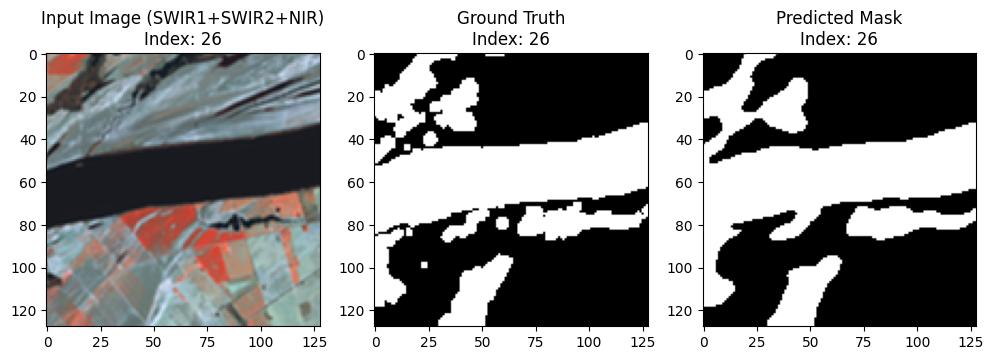

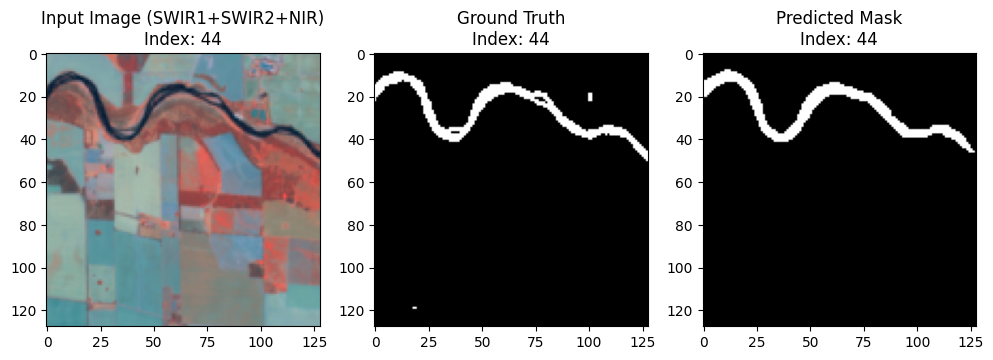

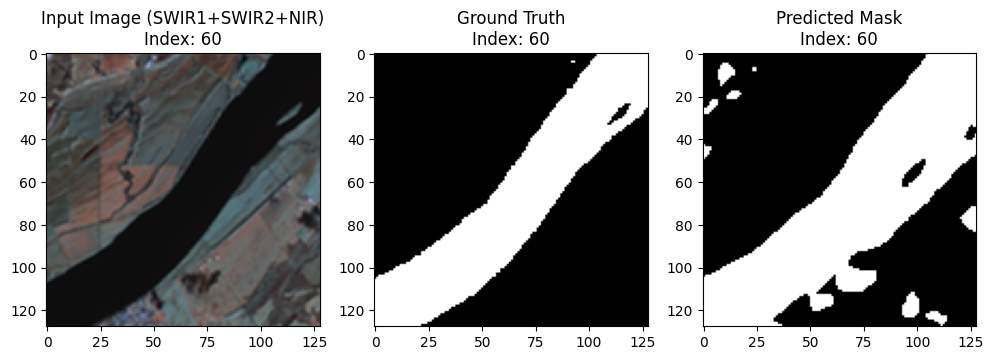

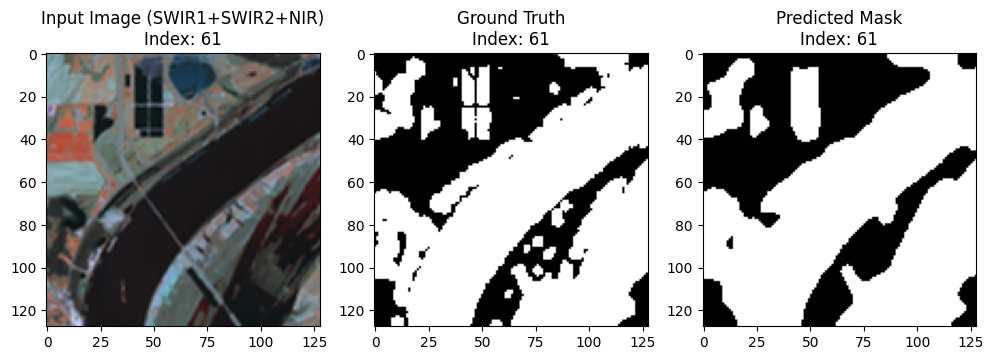

In [30]:
custom_indices = [26, 44, 60, 61]

def plot_sample(X, y_true, y_pred, idx):
    plt.figure(figsize=(12,4))

    # Input image
    plt.subplot(1,3,1)
    plt.imshow((X[idx][:,:,:3] - X[idx][:,:,:3].min()) / (X[idx][:,:,:3].max() - X[idx][:,:,:3].min()))
    plt.title(f"Input Image (SWIR1+SWIR2+NIR)\nIndex: {idx}")

    # Ground truth
    plt.subplot(1,3,2)
    plt.imshow(y_true[idx].squeeze(), cmap="gray")
    plt.title(f"Ground Truth\nIndex: {idx}")

    # Predicted mask
    plt.subplot(1,3,3)
    plt.imshow(y_pred[idx].squeeze(), cmap="gray")
    plt.title(f"Predicted Mask\nIndex: {idx}")

    plt.show()
y_pred = unet_resnet34.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(np.uint8)

for idx in custom_indices:
    plot_sample(X_test, y_test, y_pred_bin, idx)